In [127]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [45]:
import sagemaker
import boto3
import redshift_connector

In [46]:
redshift_endpoint = 'redshift-cluster-factihealth.cuzgotkwtow6.ap-south-1.redshift.amazonaws.com'
redshift_dbname = 'factihealth'
redshift_port = 5439
redshift_user = 'fh_user'
redshift_pass = 'Facti@874'

conn = redshift_connector.connect(
     host=redshift_endpoint,
     database=redshift_dbname,
     port=int(redshift_port),
     user=redshift_user,
     password=redshift_pass
  )

In [47]:
def read_table(query):
   
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]
    
    dataframe = pd.DataFrame(rows, columns=column_names)
    
    cursor.close()

    return dataframe

In [48]:
admission_query = """
SELECT *
FROM mimic.admissions
"""

patient_query = """
SELECT *
FROM mimic.patients
"""

diagnoses_icd_query = """
SELECT *
FROM mimic.diagnosis_icd
"""

icustays_query = """
SELECT *
FROM mimic.icustays
"""

In [49]:
# Primary Admissions information
df = read_table(admission_query)

# Patient specific info such as gender
df_pat = read_table(patient_query)

# Diagnosis for each admission to hospital
df_diagcode = read_table(diagnoses_icd_query)

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = read_table(icustays_query)

In [50]:
print('Dataset has {} number of unique admission events.'.format(df['hadm_id'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['subject_id'].nunique()))

Dataset has 431231 number of unique admission events.
Dataset has 180733 number of unique patients.


In [51]:
# Convert admission and discharge times to datatime type
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])

# Convert timedelta type into float 'days', 86400 seconds in a day
df['los'] = (df['dischtime'] - df['admittime']).dt.total_seconds()/86400

In [52]:
# Verify
df[['admittime', 'dischtime', 'los']].head()

,admittime,dischtime,los
0,2105-10-04 17:26:00,2105-10-12 11:11:00,7.739583
1,2106-02-06 20:18:00,2106-02-07 09:31:00,0.550694
2,2110-01-11 19:58:00,2110-01-17 16:00:00,5.834722
3,2110-01-12 00:34:00,2110-01-23 15:00:00,11.601389
4,2110-01-12 07:39:00,2110-01-12 13:20:00,0.236806


In [53]:
# Drop LOS < 0 
df = df[df['los'] > 0]

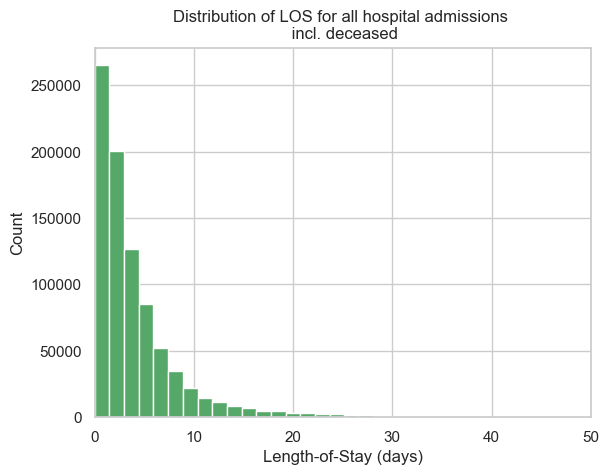

In [54]:
# Plot LOS Distribution
plt.hist(df['los'], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862178 entries, 0 to 862461
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   subject_id            862178 non-null  int64         
 1   hadm_id               862178 non-null  int64         
 2   admittime             862178 non-null  datetime64[ns]
 3   dischtime             862178 non-null  datetime64[ns]
 4   deathtime             17052 non-null   datetime64[ns]
 5   admission_type        862178 non-null  object        
 6   admit_provider_id     862178 non-null  object        
 7   admission_location    862178 non-null  object        
 8   discharge_location    862178 non-null  object        
 9   insurance             862178 non-null  object        
 10  language              862178 non-null  object        
 11  marital_status        862178 non-null  object        
 12  race                  862178 non-null  object        
 13 

In [56]:
# Pre-emptively drop some columns that I don't need anymore
df.drop(columns=['dischtime',
                'edregtime', 'edouttime', 'hospital_expire_flag'], inplace=True)

In [57]:
# Mark admissions where patients died in boolean column
df['deceased'] = df['deathtime'].notnull().map({True:1, False:0})

In [58]:
print("{} of {} patients died in the hospital".format(df['deceased'].sum(), 
                                                     df['subject_id'].nunique()))

17052 of 180677 patients died in the hospital


In [59]:
# Hospital LOS metrics for later comparison
actual_mean_los = df['los'].loc[df['deceased'] == 0].mean() 
actual_median_los = df['los'].loc[df['deceased'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

4.377160820135433
2.7159722222222222


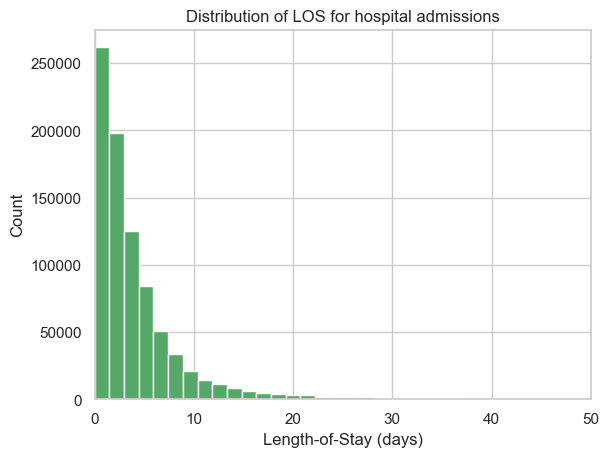

In [60]:
plt.hist(df['los'].loc[df['deceased'] == 0], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [61]:
df['race'].value_counts(dropna=False)

WHITE                                        545710
BLACK/AFRICAN AMERICAN                       119892
OTHER                                         30194
UNKNOWN                                       21288
HISPANIC/LATINO - PUERTO RICAN                16144
WHITE - OTHER EUROPEAN                        15850
HISPANIC OR LATINO                            15504
ASIAN                                         12308
ASIAN - CHINESE                               11168
WHITE - RUSSIAN                               10040
BLACK/CAPE VERDEAN                             9528
HISPANIC/LATINO - DOMINICAN                    8766
BLACK/CARIBBEAN ISLAND                         5408
BLACK/AFRICAN                                  5060
PATIENT DECLINED TO ANSWER                     3522
UNABLE TO OBTAIN                               3198
PORTUGUESE                                     3018
ASIAN - SOUTH EAST ASIAN                       2892
HISPANIC/LATINO - GUATEMALAN                   2660
ASIAN - ASIA

In [62]:
# Compress the number of ethnicity categories
df['race'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['race'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['race'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['race'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['race'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['race'].loc[~df['race'].isin(df['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['race'].value_counts()

WHITE                     576144
BLACK/AFRICAN AMERICAN    139888
OTHER/UNKNOWN              65960
HISPANIC/LATINO            50412
ASIAN                      29774
Name: race, dtype: int64

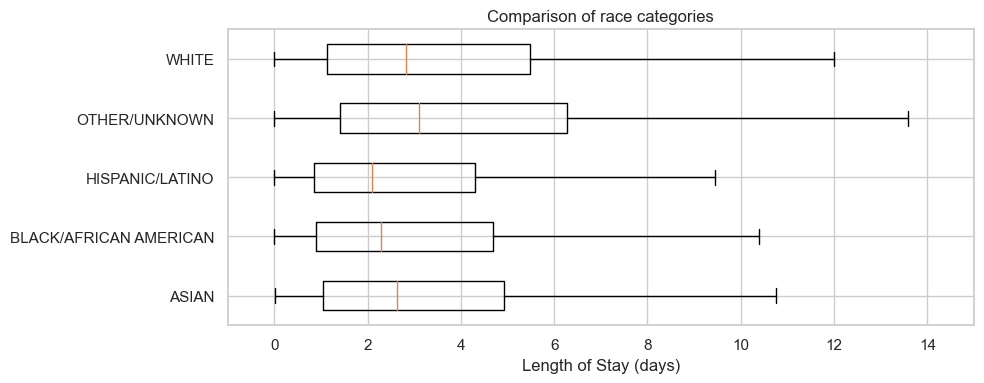

In [76]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = df[[variable, 'los']].groupby(variable).median().reset_index()
    values = list(results['los'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 15), size=(10,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = df[[variable, 'los']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['los'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

boxplot_los_groupby('race', los_range=(-1, 15))

In [77]:
df['admission_type'].value_counts(dropna=False)

EMERGENCY                      427152
OBSERVATION                    345438
SURGICAL SAME DAY ADMISSION     68458
ELECTIVE                        21130
Name: admission_type, dtype: int64

In [78]:
# Compress into EMERGENCY
df['admission_type'].replace(to_replace = 'EW EMER.', value = 'EMERGENCY', inplace = True)
df['admission_type'].replace(to_replace = 'DIRECT EMER.', value = 'EMERGENCY', inplace = True)
df['admission_type'].replace(to_replace = 'URGENT', value = 'EMERGENCY', inplace = True)

# Compress into EMERGENCY
df['admission_type'].replace(to_replace = 'EU OBSERVATION', value = 'OBSERVATION', inplace = True)
df['admission_type'].replace(to_replace = 'OBSERVATION ADMIT', value = 'OBSERVATION', inplace = True)
df['admission_type'].replace(to_replace = 'DIRECT OBSERVATION', value = 'OBSERVATION', inplace = True)
df['admission_type'].replace(to_replace = 'AMBULATORY OBSERVATION', value = 'OBSERVATION', inplace = True)

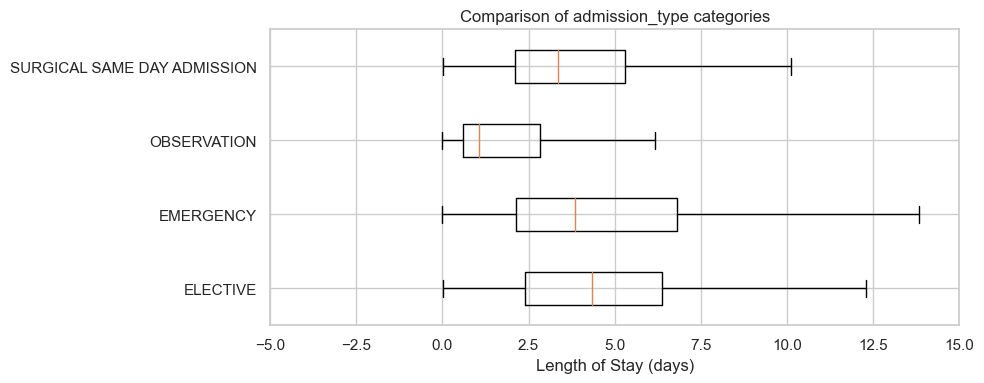

In [79]:
boxplot_los_groupby('admission_type', los_range=(-5, 15), size=(10, 4))

In [80]:
df['insurance'].value_counts()

Other       458524
Medicare    321026
Medicaid     82628
Name: insurance, dtype: int64

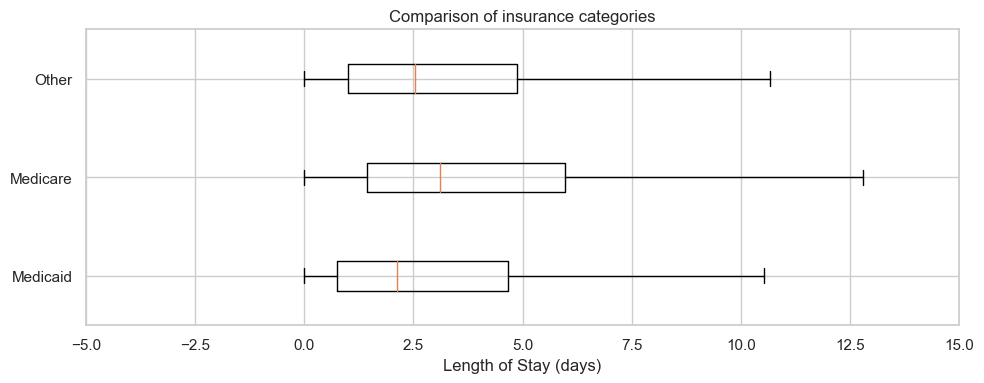

In [81]:
boxplot_los_groupby('insurance', los_range=(-5, 15), size=(10, 4))

In [82]:
df['marital_status'].value_counts(dropna=False)

MARRIED              362488
SINGLE               326324
WIDOWED               91644
DIVORCED              63306
UNKNOWN (DEFAULT)     18416
Name: marital_status, dtype: int64

In [83]:
df['marital_status'] = df['marital_status'].replace('', np.nan)

In [84]:
# Fix NaNs and file under 'UNKNOWN'
df['marital_status'] = df['marital_status'].fillna('UNKNOWN (DEFAULT)')
df['marital_status'].value_counts(dropna=False)

MARRIED              362488
SINGLE               326324
WIDOWED               91644
DIVORCED              63306
UNKNOWN (DEFAULT)     18416
Name: marital_status, dtype: int64

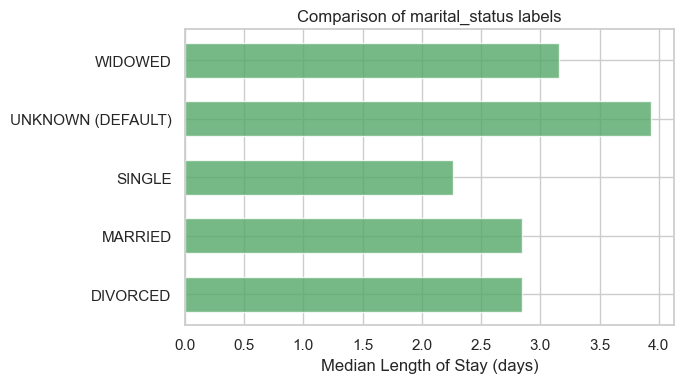

In [85]:
plot_los_groupby('marital_status')

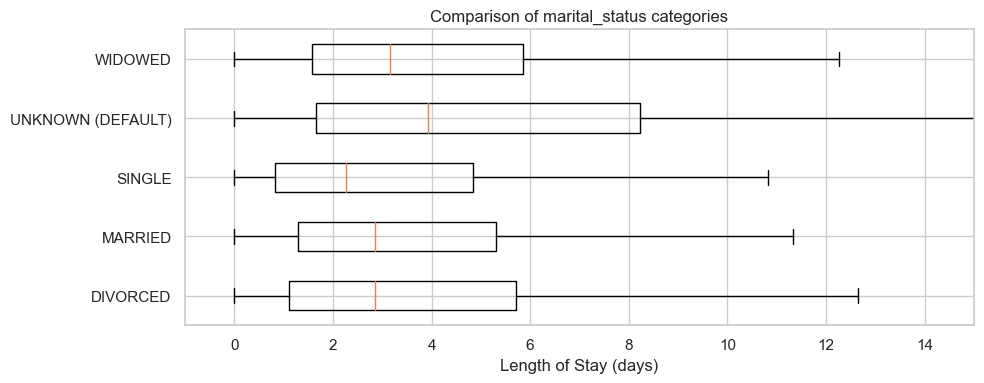

In [86]:
boxplot_los_groupby('marital_status', los_range=(-1, 15))

In [87]:
df_diagcode.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,11816842,25448380,1,0020,9
1,16992055,23051025,1,0020,9
2,12051958,25585946,1,0029,9
3,10296472,20967375,9,0030,9
4,10296472,21047134,6,0030,9


In [88]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_diagcode[df_diagcode['icd_version'] == '9']['icd_code'].value_counts().count()))

There are 9072 unique ICD9 codes in this dataset.


In [90]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['icd_code']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

In [91]:
# https://stackoverflow.com/questions/46168450/replace-specific-range-of-values-in-data-frame-pandas
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [92]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
            num, df_diagcode['recode'])
    
# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [93]:
# Verify
df_diagcode.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,recode,cat
0,11816842,25448380,1,0020,9,0,infectious
1,16992055,23051025,1,0020,9,0,infectious
2,12051958,25585946,1,0029,9,0,infectious
3,10296472,20967375,9,0030,9,0,infectious
4,10296472,21047134,6,0030,9,0,infectious


In [94]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('hadm_id')['cat'].apply(list).reset_index()
hadm_list.head()

,hadm_id,cat
0,20000019,"[infectious, endocrine, endocrine, endocrine, ..."
1,20000024,"[injury, injury, injury, injury, injury, injur..."
2,20000034,"[injury, injury, injury, injury, injury, injur..."
3,20000041,"[endocrine, endocrine, endocrine, circulatory,..."
4,20000057,"[endocrine, blood, nervous, nervous, nervous, ..."


In [95]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,1,1,1,0,3,2,1,2,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0
3,0,1,0,1,3,0,0,4,0,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,7,0,1,5,0,4,0,1,2,0


In [96]:
# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,hadm_id
0,1,1,1,0,3,2,1,2,0,0,0,0,0,0,0,1,0,20000019
1,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,20000024
2,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,20000034
3,0,1,0,1,3,0,0,4,0,0,1,0,0,0,0,0,0,20000041
4,1,1,0,0,1,0,0,7,0,1,5,0,4,0,1,2,0,20000057


In [97]:
# Merge with main admissions df
df = df.merge(hadm_item, how='inner', on='hadm_id')

In [98]:
# Verify Merge
df.head()

,subject_id,hadm_id,admittime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,16904137,21081215,2105-10-04 17:26:00,NaT,EMERGENCY,P60ZCO,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,...,1,0,0,0,1,0,0,1,0,0
1,16904137,21081215,2105-10-04 17:26:00,NaT,EMERGENCY,P60ZCO,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,...,1,0,0,0,1,0,0,1,0,0
2,14178262,24686846,2106-02-06 20:18:00,NaT,OBSERVATION,P66TM6,EMERGENCY ROOM,,Medicaid,ENGLISH,...,0,0,0,0,0,1,0,0,0,0
3,14178262,24686846,2106-02-06 20:18:00,NaT,OBSERVATION,P66TM6,EMERGENCY ROOM,,Medicaid,ENGLISH,...,0,0,0,0,0,1,0,0,0,0
4,16284044,23864737,2110-01-11 19:58:00,NaT,EMERGENCY,P41R5N,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Other,ENGLISH,...,19,0,0,0,0,0,0,0,0,0


In [99]:
df.drop_duplicates(keep='first', inplace=True)

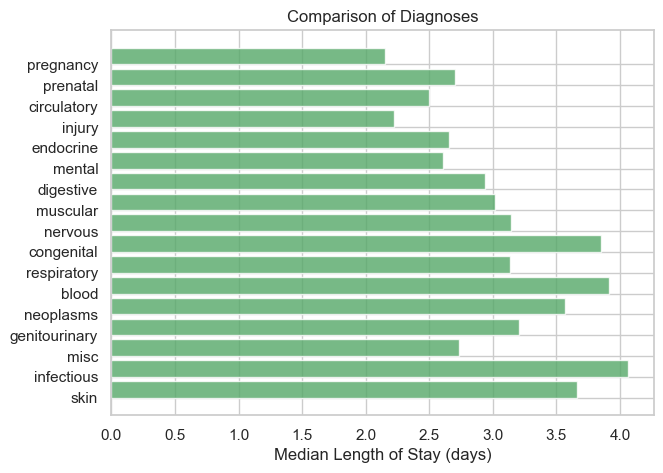

In [100]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'los']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")
#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

In [101]:
df_pat.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000048,F,23,2126,2008 - 2010,None
1,10000068,F,19,2160,2008 - 2010,None
2,10000108,M,25,2163,2014 - 2016,None
3,10000178,F,59,2157,2017 - 2019,None
4,10000280,M,20,2151,2008 - 2010,None


In [102]:
df = df.merge(df_pat[['subject_id','anchor_age', 'gender']], how='left', on='subject_id')

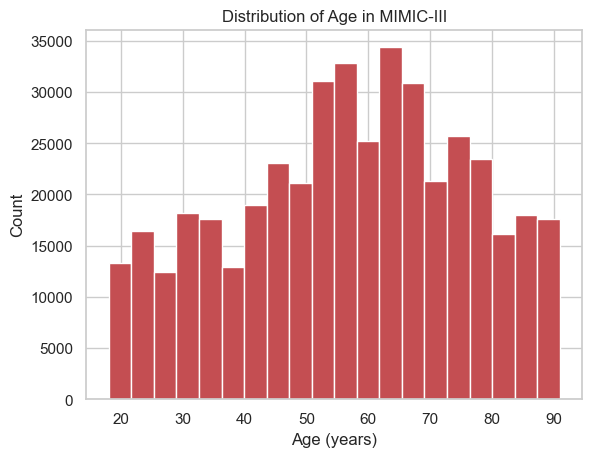

In [103]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['anchor_age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

(1.0, 50.0)

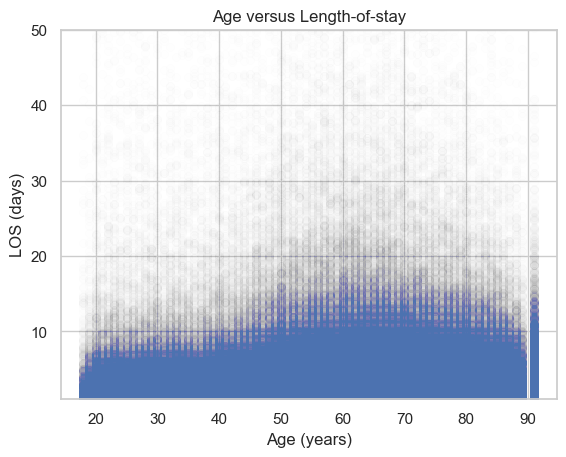

In [104]:
plt.scatter(df['anchor_age'], df['los'], alpha=0.005)
#plt.yscale('sqrt')
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

In [105]:
# https://en.wikipedia.org/wiki/List_of_ICD-9_codes
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df['anchor_age'] = np.where(df['anchor_age'].between(cat_range[0],cat_range[1]), 
            num, df['anchor_age'])
    
age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
df['age'] = df['anchor_age'].replace(age_dict)
df.age.value_counts()

senior          229536
middle_adult    123168
young_adult      78014
Name: age, dtype: int64

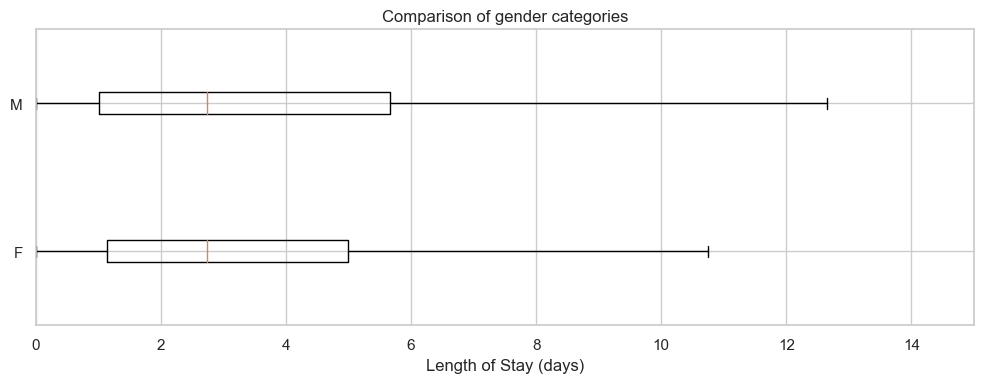

In [106]:
boxplot_los_groupby('gender', los_range=(0, 15))
df['gender'].replace({'M': 0, 'F':1}, inplace=True)

In [107]:
df_icu.groupby('first_careunit').median()


,subject_id,hadm_id,stay_id,los
first_careunit,,,,
Cardiac Vascular Intensive Care Unit (CVICU),14923590.5,24953516.0,35001421.5,1.988229
Coronary Care Unit (CCU),15021625.0,24967328.0,34892392.0,2.014063
Medical Intensive Care Unit (MICU),15021432.0,24965945.5,35057820.5,1.829288
Medical/Surgical Intensive Care Unit (MICU/SICU),14966168.0,25025525.0,34952564.0,1.808368
Neuro Intermediate,15037128.0,24917233.0,34989627.0,2.335116
Neuro Stepdown,15049025.0,25024369.0,34936685.0,1.686250
Neuro Surgical Intensive Care Unit (Neuro SICU),15181278.5,25005716.5,34857355.0,3.651233
Surgical Intensive Care Unit (SICU),14988679.0,24874195.0,35010700.0,1.974583
Trauma SICU (TSICU),15060616.5,25060356.5,35049081.0,1.939421


In [108]:
# Based on above statistics, reduce to just ICU and NICU groups
df_icu['first_careunit'].replace({'Cardiac Vascular Intensive Care Unit (CVICU)': 'Other-ICU', 'Coronary Care Unit (CCU)': 'Other-ICU', 
                                    'Medical Intensive Care Unit (MICU)': 'Other-ICU','Medical/Surgical Intensive Care Unit (MICU/SICU)': 'Other-ICU',
                                    'Neuro Stepdown': 'Other-ICU', 'Surgical Intensive Care Unit (SICU)': 'Other-ICU', 
                                    'Trauma SICU (TSICU)': 'Other-ICU'}, inplace=True)

In [109]:
df_icu['cat'] = df_icu['first_careunit']
icu_list = df_icu.groupby('hadm_id')['cat'].apply(list).reset_index()

In [110]:
df_icu['first_careunit'].value_counts()

Other-ICU                                          69384
Neuro Intermediate                                  2035
Neuro Surgical Intensive Care Unit (Neuro SICU)     1762
Name: first_careunit, dtype: int64

In [111]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['hadm_id'], how="outer")
icu_item.head()

,Neuro Intermediate,Neuro Surgical Intensive Care Unit (Neuro SICU),Other-ICU,hadm_id
0,0,0,1,20000094
1,0,0,1,20000147
2,0,0,1,20000351
3,0,0,1,20000808
4,0,0,1,20001305


In [112]:
# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='left', on='hadm_id')

In [113]:
# Replace NaNs with 0
df['Neuro Intermediate'].fillna(value=0, inplace=True)
df['Neuro Surgical Intensive Care Unit (Neuro SICU)'].fillna(value=0, inplace=True)
df['Other-ICU'].fillna(value=0, inplace=True)

In [114]:
# Remove deceased persons as they will skew LOS result
df = df[df['deceased'] == 0]

# Remove LOS with negative number, likely entry form error
df = df[df['los'] > 0]

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422214 entries, 0 to 430717
Data columns (total 37 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   subject_id                                       422214 non-null  int64         
 1   hadm_id                                          422214 non-null  int64         
 2   admittime                                        422214 non-null  datetime64[ns]
 3   deathtime                                        0 non-null       datetime64[ns]
 4   admission_type                                   422214 non-null  object        
 5   admit_provider_id                                422214 non-null  object        
 6   admission_location                               422214 non-null  object        
 7   discharge_location                               422214 non-null  object        
 8   insurance               

In [116]:
# Drop unused or no longer needed columns
df.drop(columns=['subject_id', 'hadm_id', 'admittime', 'deathtime',
                 'admit_provider_id', 'admission_location', 'discharge_location',
                 'language', 'deceased', 'anchor_age'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422214 entries, 0 to 430717
Data columns (total 27 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   admission_type                                   422214 non-null  object 
 1   insurance                                        422214 non-null  object 
 2   marital_status                                   422214 non-null  object 
 3   race                                             422214 non-null  object 
 4   los                                              422214 non-null  float64
 5   blood                                            422214 non-null  uint8  
 6   circulatory                                      422214 non-null  uint8  
 7   congenital                                       422214 non-null  uint8  
 8   digestive                                        422214 non-null  uint8  
 9   endocrine      

In [117]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'RACE', 'AGE', 'MAR']
dummy_cols = ['admission_type', 'insurance',
             'race', 'age', 'marital_status']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422214 entries, 0 to 430717
Data columns (total 42 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   los                                              422214 non-null  float64
 1   blood                                            422214 non-null  uint8  
 2   circulatory                                      422214 non-null  uint8  
 3   congenital                                       422214 non-null  uint8  
 4   digestive                                        422214 non-null  uint8  
 5   endocrine                                        422214 non-null  uint8  
 6   genitourinary                                    422214 non-null  uint8  
 7   infectious                                       422214 non-null  uint8  
 8   injury                                           422214 non-null  uint8  
 9   mental         

In [118]:
# Verify
df.head()

,los,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,RACE_OTHER/UNKNOWN,RACE_WHITE,AGE_middle_adult,AGE_senior,AGE_young_adult,MAR_DIVORCED,MAR_MARRIED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED
0,7.739583,1,1,0,1,1,1,0,1,0,...,1,0,1,0,0,0,1,0,0,0
1,0.550694,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,5.834722,0,0,0,0,0,0,0,19,0,...,0,1,0,1,0,1,0,0,0,0
3,11.601389,0,1,0,1,0,1,1,2,0,...,0,1,0,1,0,0,1,0,0,0
4,0.236806,0,0,0,0,0,0,0,1,1,...,1,0,0,0,1,0,0,1,0,0


In [119]:
df.shape

(422214, 42)

In [120]:
df_clean = df.copy()

In [121]:
df_clean.columns

Index(['los', 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine',
       'genitourinary', 'infectious', 'injury', 'mental', 'misc', 'muscular',
       'neoplasms', 'nervous', 'pregnancy', 'prenatal', 'respiratory', 'skin',
       'gender', 'Neuro Intermediate',
       'Neuro Surgical Intensive Care Unit (Neuro SICU)', 'Other-ICU',
       'ADM_ELECTIVE', 'ADM_EMERGENCY', 'ADM_OBSERVATION',
       'ADM_SURGICAL SAME DAY ADMISSION', 'INS_Medicaid', 'INS_Medicare',
       'INS_Other', 'RACE_ASIAN', 'RACE_BLACK/AFRICAN AMERICAN',
       'RACE_HISPANIC/LATINO', 'RACE_OTHER/UNKNOWN', 'RACE_WHITE',
       'AGE_middle_adult', 'AGE_senior', 'AGE_young_adult', 'MAR_DIVORCED',
       'MAR_MARRIED', 'MAR_SINGLE', 'MAR_UNKNOWN (DEFAULT)', 'MAR_WIDOWED'],
      dtype='object')

In [122]:
# Target Variable (Length-of-Stay)
LOS = df_clean['los'].values
# Prediction Features
features = df_clean.drop(columns=['los'])

In [123]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 337771 samples.
Testing set has 84443 samples.


In [128]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0),
          xgb.XGBRegressor(random_state = 0)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.
XGBRegressor done.


Text(0.5, 1.0, 'Comparison of Regression Models')

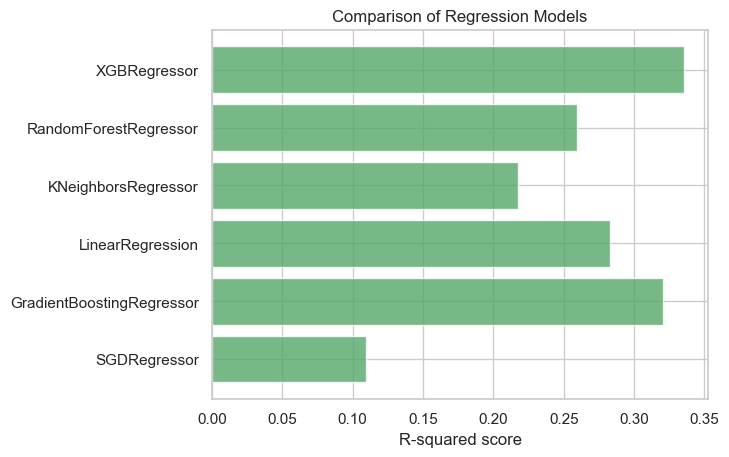

In [129]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
# fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [130]:
# GradientBoostingRegressor will be used as the LOS prediction model
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.320743


In [131]:
reg_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [134]:
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import GradientBoostingRegressor
import time

# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size=0.20, 
                                                    random_state=42)

# Set the parameters by cross-validation
tuned_parameters = {
    'n_estimators': [100, 500, 1000],  # Number of trees in the forest
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 6, 10],  # Maximum depth of a tree
    'colsample_bytree': [0.3, 0.7, 1.0],  # Subsample ratio of columns when constructing each tree
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    'alpha': [0, 1, 10]  # L1 regularization term on weights
}

# Calculate total number of iterations
total_iterations = len(tuned_parameters['n_estimators']) * \
                   len(tuned_parameters['learning_rate']) * \
                   len(tuned_parameters['max_depth']) * \
                   len(tuned_parameters['colsample_bytree']) * \
                   len(tuned_parameters['subsample']) * \
                   len(tuned_parameters['alpha'])
print(f"Total iterations to be performed: {total_iterations}")

# Create and fit a ridge regression model, testing each alpha
reg_model = xgb.XGBRegressor(objective='reg:squarederror')
grid = GridSearchCV(estimator=reg_model, param_grid=tuned_parameters, 
                           scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=2)  # Set verbose to 2 for more detailed logging
start_time = time.time()
grid.fit(X_train, y_train)
end_time = time.time()

# Summarize the results of the grid search
print(f"Best score: {grid.best_score_}")
print(f"Best estimator: {grid.best_estimator_}")
print(f"Total tuning time: {end_time - start_time} seconds")


Total iterations to be performed: 729
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.9s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.9s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   3.7s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   4.2s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   4.2s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   4.4s
[CV] END alpha=0, colsa

In [135]:
print(f"Best score: {grid.best_score_}")
print(f"Best estimator: {grid.best_estimator_}")

Best score: -26.86054846358483
Best estimator: XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)


In [150]:
X_train.columns

Index(['blood', 'circulatory', 'congenital', 'digestive', 'endocrine',
       'genitourinary', 'infectious', 'injury', 'mental', 'misc', 'muscular',
       'neoplasms', 'nervous', 'pregnancy', 'prenatal', 'respiratory', 'skin',
       'gender', 'Neuro Intermediate',
       'Neuro Surgical Intensive Care Unit (Neuro SICU)', 'Other-ICU',
       'ADM_ELECTIVE', 'ADM_EMERGENCY', 'ADM_OBSERVATION',
       'ADM_SURGICAL SAME DAY ADMISSION', 'INS_Medicaid', 'INS_Medicare',
       'INS_Other', 'RACE_ASIAN', 'RACE_BLACK/AFRICAN AMERICAN',
       'RACE_HISPANIC/LATINO', 'RACE_OTHER/UNKNOWN', 'RACE_WHITE',
       'AGE_middle_adult', 'AGE_senior', 'AGE_young_adult', 'MAR_DIVORCED',
       'MAR_MARRIED', 'MAR_SINGLE', 'MAR_UNKNOWN (DEFAULT)', 'MAR_WIDOWED'],
      dtype='object')

In [136]:
#reg_model = GradientBoostingRegressor(n_estimators = 300, max_depth=4, loss='huber')   
#reg_model.fit(X_train, y_train)

reg_model_optimized = grid.best_estimator_

y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized)) 

Optimized R2 score is: 0.353977


In [137]:
print('Model refinement improved R2 score by {:.4f}'.format(r2_optimized-r2_not_refined))


Model refinement improved R2 score by 0.0332


In [138]:
feature_imp = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
Other-ICU,0.186081
ADM_EMERGENCY,0.157148
injury,0.131128
ADM_OBSERVATION,0.116753
Neuro Surgical Intensive Care Unit (Neuro SICU),0.045536
infectious,0.039467
respiratory,0.029791
ADM_ELECTIVE,0.022941
blood,0.022554
misc,0.019511


In [139]:
feature_imp.index[0:10].tolist()

['Other-ICU',
 'ADM_EMERGENCY',
 'injury',
 'ADM_OBSERVATION',
 'Neuro Surgical Intensive Care Unit (Neuro SICU)',
 'infectious',
 'respiratory',
 'ADM_ELECTIVE',
 'blood',
 'misc']

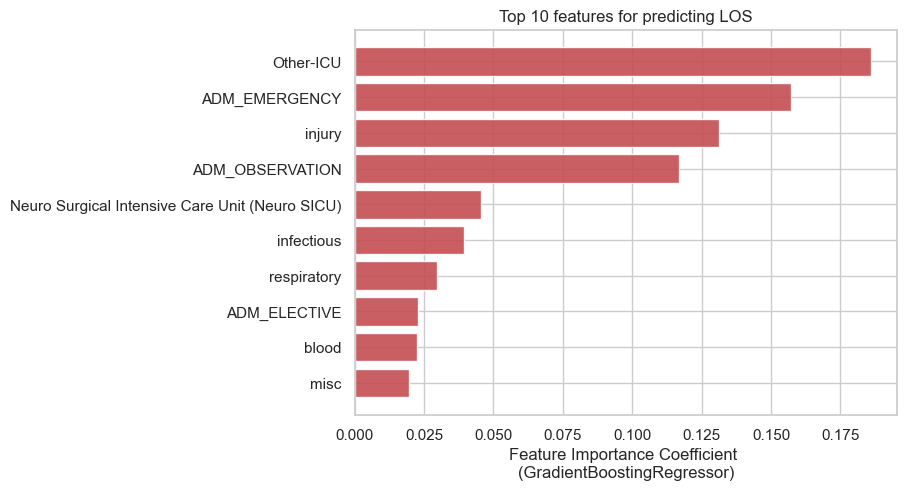

In [140]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10], 
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting LOS")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()
# fig.savefig('images/feature_importance.png', bbox_inches = 'tight')

In [145]:
LOS_actual = y_test[:50]
LOS_predict = y_test_preds[:50]

In [146]:
len(y_test_preds)

84443

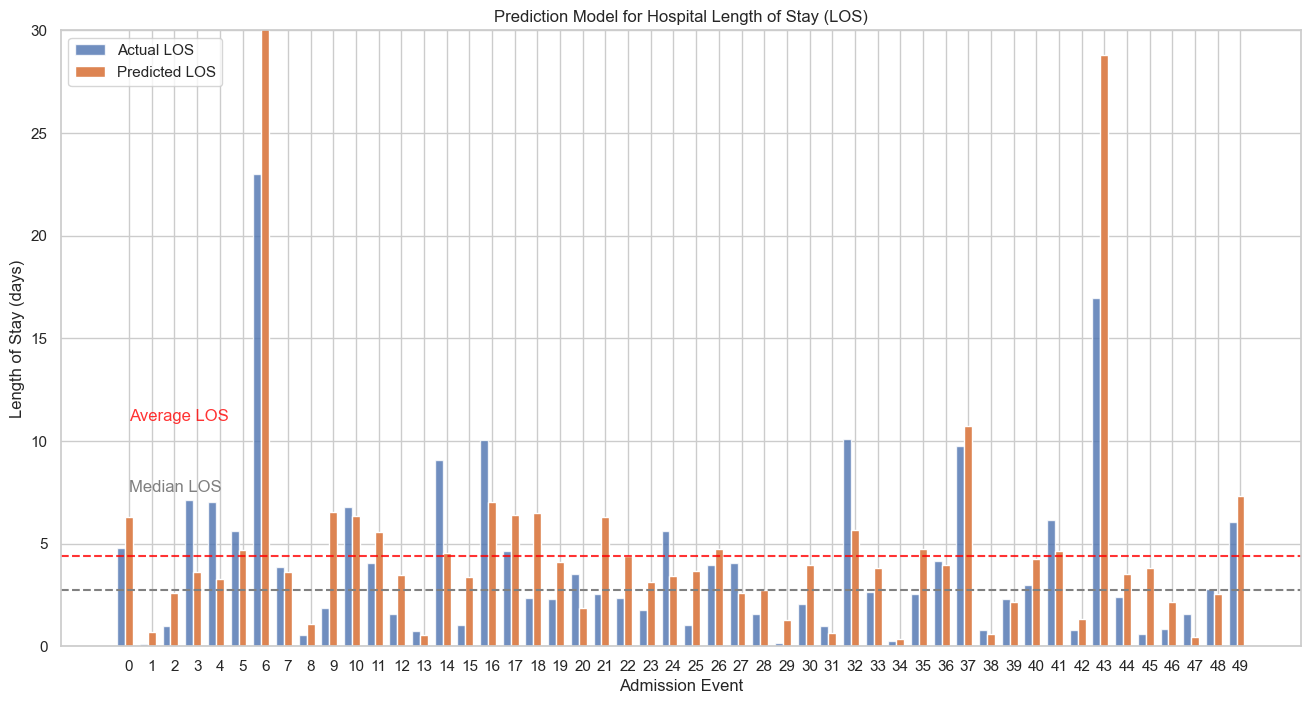

In [148]:
fig, ax = plt.subplots(figsize=(16, 8))

# https://matplotlib.org/examples/api/barchart_demo.html
ind = np.arange(0,50)
pad = 0.15
width = 0.35
set_actual = ax.bar(pad+ind, LOS_actual, width, color='#4c72b0', alpha=0.8)
set_predict = ax.bar(pad+ind+width, LOS_predict, width, color='#dd8452')

ax.set_ylabel('Length of Stay (days)')
ax.set_xlabel('Admission Event')
ax.set_title('Prediction Model for Hospital Length of Stay (LOS)')
ax.text(0.5, 11, 'Average LOS', fontdict=None, color='red', alpha=0.8)
ax.text(0.5, 7.5, 'Median LOS', fontdict=None, color='gray')
ax.set_xticks(pad + ind + width)
ax.set_ylim(0, 30)
ax.set_xticklabels(list(range(50)))
ax.axhline(y=actual_median_los, xmin=0, xmax=50, ls='--', color='gray')
ax.axhline(y=actual_mean_los, xmin=0, xmax=50, ls='--', color='red', alpha=0.8)
ax.legend( (set_actual, set_predict), ('Actual LOS', 'Predicted LOS'), 
          loc='upper left')
ax.tick_params(bottom=False, top=False, right=False)

In [149]:
# #y_test_preds = reg_model.predict(X_test)

ml_count, md_count, avg_count  = 0, 0, 0
ml_days, md_days, avg_days  = 0, 0, 0
ml_days_rms, md_days_rms, avg_days_rms  = 0, 0, 0

for i in range(y_test_preds.shape[0]):
    ml_model = abs(y_test_preds[i] - y_test[i])
    median_model = abs(actual_median_los - y_test[i])
    average_model = abs(actual_mean_los - y_test[i])
    
    ml_days += ml_model
    md_days += median_model
    avg_days += average_model
    
    ml_model_rms = (y_test_preds[i] - y_test[i])**2
    median_model_rms = (actual_median_los - y_test[i])**2
    average_model_rms = (actual_mean_los - y_test[i])**2
    
    ml_days_rms += ml_model_rms
    md_days_rms += median_model_rms
    avg_days_rms += average_model_rms

print("Prediction Model days {}".format(ml_days/y_test_preds.shape[0]))
print("Median Model days {}".format(md_days/y_test_preds.shape[0]))
print("Average Model days {}".format(avg_days/y_test_preds.shape[0]))

print("Prediction Model RMS {}".format((ml_days_rms**0.5)/y_test_preds.shape[0]))
print("Median Model RMS {}".format((md_days_rms**0.5)/y_test_preds.shape[0]))
print("Average Model RMS {}".format((avg_days_rms**0.5)/y_test_preds.shape[0]))

Prediction Model days 2.4875332441502156
Median Model days 3.115545282353484
Average Model days 3.472000263206686
Prediction Model RMS 0.017137217829347174
Median Model RMS 0.022044940313438253
Average Model RMS 0.021321740959988556


In [152]:
import pickle 

with open('los_model_xgboost.pkl', 'wb') as file:  
    pickle.dump(reg_model_optimized, file)

In [153]:
model.save_model('model.json')